# Features engineer

# Train on rank on groupby chr

🔒 Global seed set to 42

🏁 Running TSS=500

 🔁 LOCO (../preprocessed_data/reference/1. merged data/with_y_500): X1 → X2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]	train's l2: 0.0113872	val's l2: 0.0305902
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[495]	train's l2: 0.011676	val's l2: 0.0283721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	train's l2: 0.0123001	val's l2: 0.0273205
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[853]	train's l2: 0.0110507	val's l2: 0.0294289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	train's l2: 0.0120535	val's l2: 0.0311765
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[503]	train's l2: 0.0118525	val's l2: 0.0278142
Training un

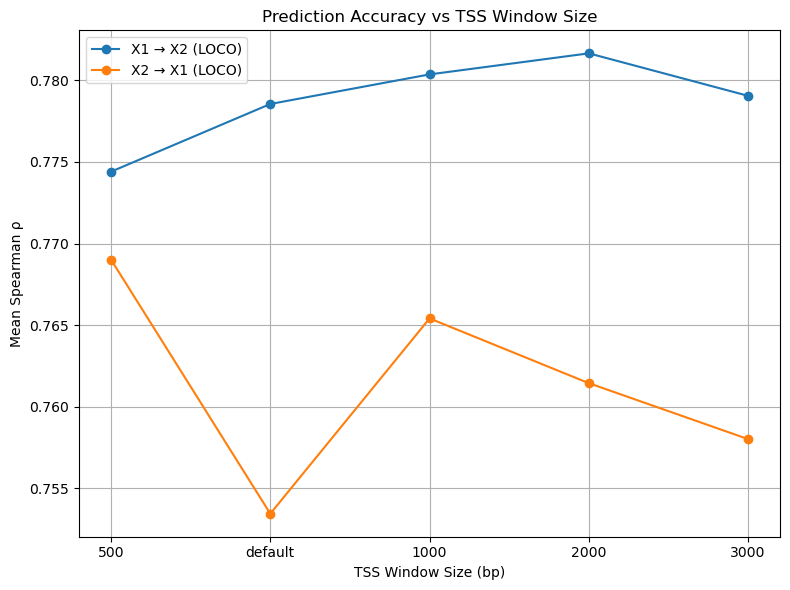

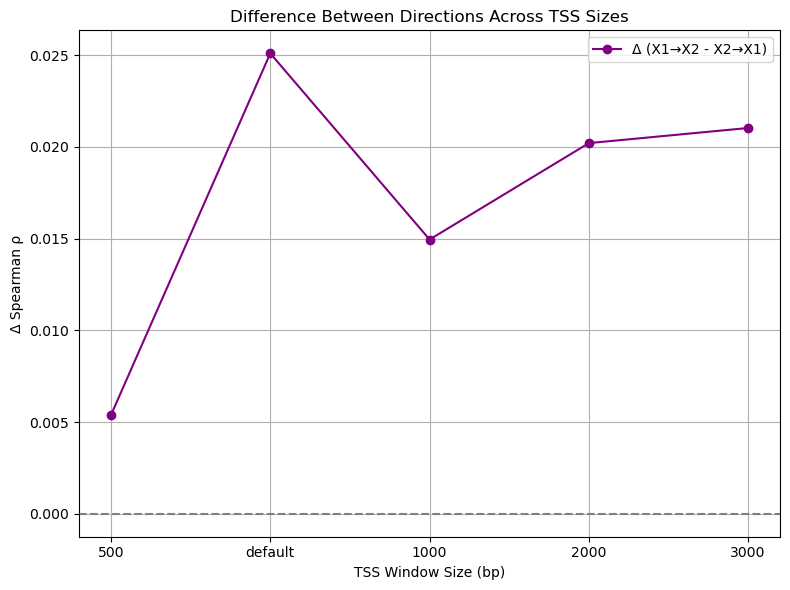

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
BASE_DIRS = [
    "../preprocessed_data/reference/1. merged data/with_y_500",
    "../preprocessed_data/reference/1. merged data/with_y",
    "../preprocessed_data/reference/1. merged data/with_y_1000",
    "../preprocessed_data/reference/1. merged data/with_y_2000",
    "../preprocessed_data/reference/1. merged data/with_y_3000",
]
META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
chromosomes = [f"chr{i}" for i in range(2, 23)]

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
    }

# ============================================================
#                  FUNCTION: LOCO EXPERIMENT
# ============================================================
def run_loco(train_name, val_name, data_dir):
    """Perform Leave-One-Chromosome-Out CV."""
    print(f"\n==============================")
    print(f" 🔁 LOCO ({data_dir}): {train_name} → {val_name}")
    print(f"==============================")

    df_train_full = pd.read_csv(f"{data_dir}/{train_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    df_val_full   = pd.read_csv(f"{data_dir}/{val_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

    results = []

    for chrom_val in chromosomes:
        df_train = df_train_full[df_train_full["chr"] != chrom_val].copy()
        df_val   = df_val_full[df_val_full["chr"] == chrom_val].copy()

        if df_val.empty:
            continue

        X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
        X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dtrain, dval],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0)
            ],
        )

        df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)
        rho = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
        results.append({"chr": chrom_val, "spearman": rho})

    summary_loco = pd.DataFrame(results)
    mean_loco = summary_loco["spearman"].mean()

    # --- Full model baseline ---
    X_train_full, y_train_full = df_train_full[feature_cols], df_train_full[TARGET_COL]
    X_val_full, y_val_full     = df_val_full[feature_cols], df_val_full[TARGET_COL]

    dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)
    dval_full   = lgb.Dataset(X_val_full, label=y_val_full, reference=dtrain_full)

    full_model = lgb.train(
        params,
        dtrain_full,
        valid_sets=[dtrain_full, dval_full],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ],
    )

    df_val_full["pred_full"] = full_model.predict(X_val_full, num_iteration=full_model.best_iteration)
    rho_full = spearmanr(df_val_full[TARGET_COL], df_val_full["pred_full"])[0]

    return mean_loco, rho_full

# ============================================================
#                  MAIN LOOP OVER TSS WINDOW SIZES
# ============================================================
results_summary = []

for data_dir in BASE_DIRS:
    tss_label = os.path.basename(data_dir).replace("with_y_", "").replace("with_y", "default")

    print(f"\n🏁 Running TSS={tss_label}")
    mean_X1_to_X2, full_X1_to_X2 = run_loco("X1", "X2", data_dir)
    mean_X2_to_X1, full_X2_to_X1 = run_loco("X2", "X1", data_dir)

    results_summary.append({
        "TSS": tss_label,
        "X1_to_X2": mean_X1_to_X2,
        "X2_to_X1": mean_X2_to_X1,
        "X1_to_X2_full": full_X1_to_X2,
        "X2_to_X1_full": full_X2_to_X1,
        "diff": mean_X1_to_X2 - mean_X2_to_X1
    })

In [29]:
def run_all(data_dir, mode="loco", n_splits=5):
    """
    Perform CV (LOCO / Chromosome-KFold / KFold)
    on merged X1 + X2 dataset, while tracking each subset’s performance.

    Returns:
        X1_mean, X2_mean, X1_rho, X2_rho
    """
    print(f"\n==============================")
    print(f" 🔁 {mode.upper()} CV | Merged X1 + X2 | {data_dir}")
    print(f"==============================")

    # === Load datasets ===
    df_X1 = pd.read_csv(f"{data_dir}/X1_all_logzscore_logzscore_with_y.tsv", sep="\t")
    df_X2 = pd.read_csv(f"{data_dir}/X2_all_logzscore_logzscore_with_y.tsv", sep="\t")
    df_X1["cell"] = "X1"
    df_X2["cell"] = "X2"

    # --- Merge ---
    df_all = pd.concat([df_X1, df_X2], axis=0, ignore_index=True)
    feature_cols = [c for c in df_all.columns if c not in META_COLS + ["cell"]]
    results = []

    # ============================================================
    # 🧬 LOCO
    # ============================================================
    if mode == "loco":
        for chrom_val in chromosomes:
            df_train = df_all[df_all["chr"] != chrom_val].copy()
            df_val   = df_all[df_all["chr"] == chrom_val].copy()

            if df_val.empty:
                print(f"⚠️ Skip {chrom_val} — no validation samples")
                continue

            X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
            X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

            if len(X_train) == 0 or len(X_val) == 0:
                print(f"⚠️ Skip {chrom_val} — missing training or validation data")
                continue

            dtrain = lgb.Dataset(X_train, label=y_train)
            dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

            model = lgb.train(
                params,
                dtrain,
                valid_sets=[dtrain, dval],
                valid_names=["train", "val"],
                num_boost_round=2000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ],
            )

            preds = model.predict(X_val, num_iteration=model.best_iteration)
            df_val["pred"] = preds
            results.append(df_val[["gene_name", "chr", "cell", TARGET_COL, "pred"]])

    elif mode == "chrom_kfold":
        chrom_folds = [chromosomes[i::n_splits] for i in range(n_splits)]
        for i, chrom_group in enumerate(chrom_folds):
            print(f"\n🚀 Chromosome-KFold {i+1}/{n_splits}: Valid={chrom_group}")
            df_train = df_all[~df_all["chr"].isin(chrom_group)].copy()
            df_val   = df_all[df_all["chr"].isin(chrom_group)].copy()
            if df_val.empty:
                print(f"⚠️ Skip fold {i+1} — no val chromosomes")
                continue

            X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
            X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

            if len(X_train) == 0 or len(X_val) == 0:
                print(f"⚠️ Skip fold {i+1} — missing data")
                continue

            dtrain = lgb.Dataset(X_train, label=y_train)
            dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

            model = lgb.train(
                params,
                dtrain,
                valid_sets=[dtrain, dval],
                valid_names=["train", "val"],
                num_boost_round=2000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ],
            )

            df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)
            results.append(df_val[["gene_name", "chr", "cell", TARGET_COL, "pred"]])
        print(results)
    else:
        raise ValueError(f"❌ Unknown mode: {mode}")

        # ============================================================
    # 📊 Combine & Evaluate
    # ============================================================
    if not results:
        raise ValueError("❌ No valid folds were processed — check your chromosomes or data!")

    df_pred = pd.concat(results, axis=0, ignore_index=True)
    print(f"\n📘 Combined CV predictions: {df_pred.shape}")

    # ============================================================
    # 📈 Spearman evaluation
    # ============================================================
    def _compute_spearman(subset, label):
        if subset.empty:
            print(f"⚠️ {label} subset is empty")
            return np.nan
        rho = spearmanr(subset[TARGET_COL], subset["pred"])[0]
        print(f"📈 {label} Spearman ρ = {rho:.4f}")
        return rho

    # -- Mean Spearman by cell
    X1_mean = _compute_spearman(df_pred[df_pred["cell"] == "X1"], "X1 Mean (CV)")
    X2_mean = _compute_spearman(df_pred[df_pred["cell"] == "X2"], "X2 Mean (CV)")

    # -- Global (all merged) mean
    global_mean = _compute_spearman(df_pred, "Global Mean (CV)")

    # ============================================================
    # ✅ Summary
    # ============================================================
    print("\n==============================")
    print("📊 Final Summary Across Subsets")
    print("==============================")
    print(f"X1 : Mean(CV)={X1_mean:.4f}")
    print(f"X2 : Mean(CV)={X2_mean:.4f}")
    print(f"Global Mean(CV)={global_mean:.4f}")
    print(f"Δ_mean = {X1_mean - X2_mean:.4f}")
    print("==============================")

    return X1_mean, X2_mean, global_mean


In [15]:
data_dir

'../preprocessed_data/reference/1. merged data/with_y_500'


🏁 Running TSS=500

 🔁 LOCO CV | Merged X1 + X2 | ../preprocessed_data/reference/1. merged data/with_y_500
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1032]	train's l2: 0.0120002	val's l2: 0.0216825
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[669]	train's l2: 0.0131517	val's l2: 0.0196079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1350]	train's l2: 0.0118774	val's l2: 0.0179724
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[763]	train's l2: 0.0128723	val's l2: 0.0192092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	train's l2: 0.0159682	val's l2: 0.0236392
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1361]	train's l2: 0.011873	val's l2: 0.0179013
Training until valida

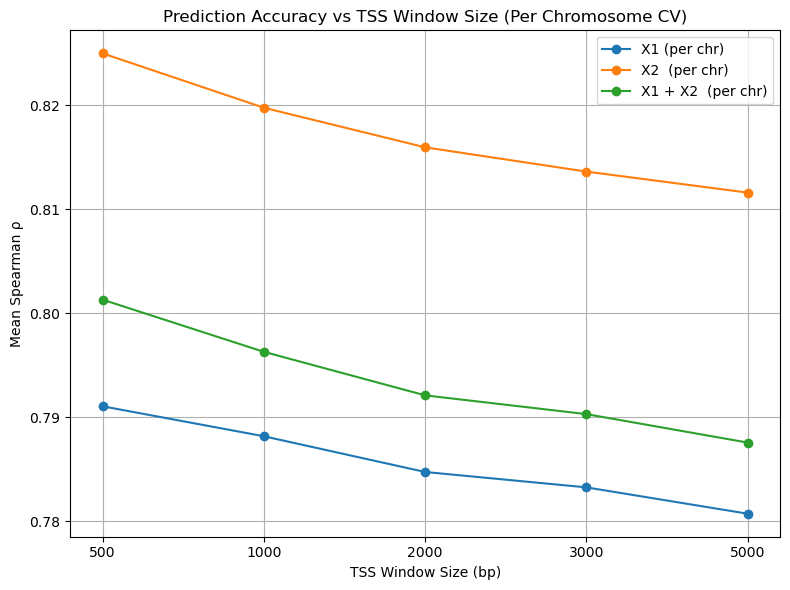

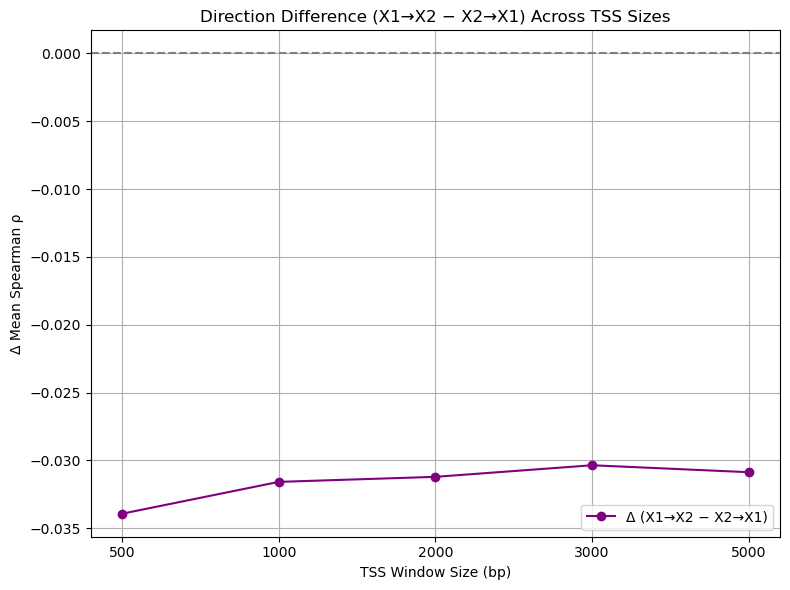

In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# ⚙️ 參數設定
# ============================================================
BASE_DIRS = [
    "../preprocessed_data/reference/1. merged data/with_y_500",
    "../preprocessed_data/reference/1. merged data/with_y_1000",
    "../preprocessed_data/reference/1. merged data/with_y_2000",
    "../preprocessed_data/reference/1. merged data/with_y_3000",

    "../preprocessed_data/reference/1. merged data/with_y"  # default=5000
]

results_summary_all = []

# ============================================================
# 🚀 主迴圈：跑多個 TSS window
# ============================================================
for data_dir in BASE_DIRS:
    tss_label = os.path.basename(data_dir).replace("with_y_", "").replace("with_y", "5000")
    print(f"\n🏁 Running TSS={tss_label}")
    X1_mean, X2_mean, X1_X2_mean = run_all(data_dir, mode="loco")#chrom_kfold

    results_summary_all.append({
        "TSS": tss_label,
        "X1_integrate": X1_mean,
        "X2_integrate": X2_mean,
        "all": X1_X2_mean,
        "diff": X1_mean - X2_mean
    })


# ============================================================
# 🧾 Summary 整理與排序
# ============================================================
summary_df_2 = pd.DataFrame(results_summary_all)
summary_df_2["TSS"] = summary_df_2["TSS"].astype(str).replace("default", "5000")
summary_df_2 = summary_df_2.sort_values("TSS", key=lambda s: s.map(int))

print("\n===== 📊 Summary of All TSS Window Sizes =====")
print(summary_df_2)

# ============================================================
# 📈 視覺化 1：Mean Spearman (per chr)
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(summary_df_2["TSS"], summary_df_2["X1_integrate"], marker='o', label="X1 (per chr)")
plt.plot(summary_df_2["TSS"], summary_df_2["X2_integrate"], marker='o', label="X2  (per chr)")
plt.plot(summary_df_2["TSS"], summary_df_2["all"], marker='o', label="X1 + X2  (per chr)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Mean Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size (Per Chromosome CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ============================================================
# 📈 視覺化 3：方向差距 Δ
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(summary_df_2["TSS"], summary_df_2["diff"], marker='o', color='purple', label="Δ (X1→X2 − X2→X1)")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Δ Mean Spearman ρ")
plt.title("Direction Difference (X1→X2 − X2→X1) Across TSS Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


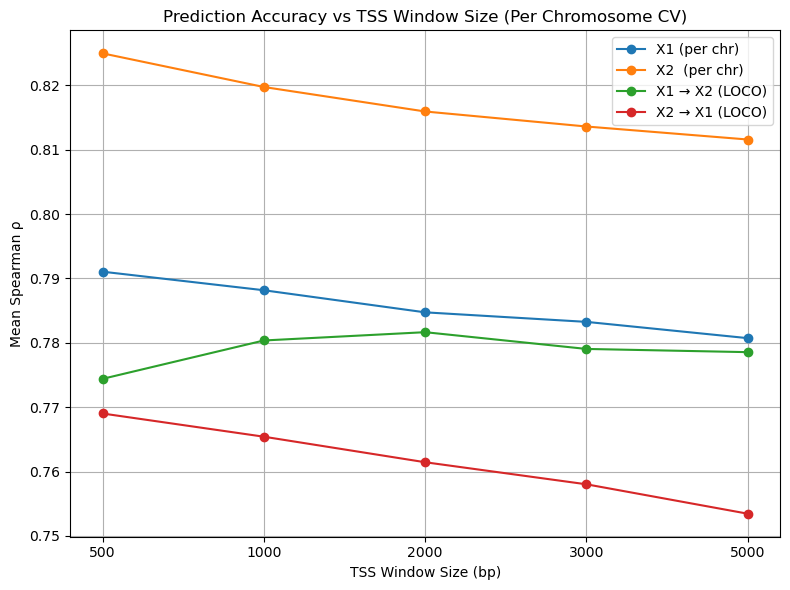

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(summary_df_2["TSS"], summary_df_2["X1_integrate"], marker='o', label="X1 (integrated LOCO)")
plt.plot(summary_df_2["TSS"], summary_df_2["X2_integrate"], marker='o', label="X2 (integrated LOCO)")
plt.plot(summary_df["TSS"], summary_df["X1_to_X2"], marker='o', label="X1 → X2 (LOCO)")
plt.plot(summary_df["TSS"], summary_df["X2_to_X1"], marker='o', label="X2 → X1 (LOCO)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Mean Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size in both sides (Integrated vs Cross-Cell LOCO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scripts.tss_compare import run_all, run_cv
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
BASE_DIRS = [
    "../preprocessed_data/reference/1. merged data/with_y_500_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_5000_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_1000_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_2000_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_3000_one_side",
]
META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
chromosomes = [f"chr{i}" for i in range(2, 23)]

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
    }


# ============================================================
#                  MAIN LOOP OVER TSS WINDOW SIZES
# ============================================================
results_summary_new = []

for data_dir in BASE_DIRS:
    tss_label = os.path.basename(data_dir).replace("with_y_", "").replace("with_y", "default")

    print(f"\n🏁 Running TSS={tss_label}")
    mean_X1_to_X2 = run_cv("X1", "X2", data_dir, META_COLS, TARGET_COL, chromosomes, params , mode="loco", n_splits=5)
    mean_X2_to_X1 = run_cv("X2", "X1", data_dir, META_COLS, TARGET_COL, chromosomes, params , mode="loco", n_splits=5)
    X1_mean, X2_mean, X1_X2_mean = run_all(data_dir, META_COLS, TARGET_COL, chromosomes, params , mode="loco", n_splits=5)

    results_summary_new.append({
        "TSS": tss_label,
        "X1_to_X2": mean_X1_to_X2,
        "X2_to_X1": mean_X2_to_X1,
        "X1_integrate": X1_mean,
        "X2_integrate": X2_mean,
    })
    
plt.figure(figsize=(8,6))
plt.plot(results_summary_new["TSS"], results_summary_new["X1_integrate"], marker='o', label="X1 (per chr)")
plt.plot(results_summary_new["TSS"], results_summary_new["X2_integrate"], marker='o', label="X2  (per chr)")
plt.plot(results_summary_new["TSS"], results_summary_new["X1_to_X2"], marker='o', label="X1 → X2 (LOCO)")
plt.plot(results_summary_new["TSS"], results_summary_new["X2_to_X1"], marker='o', label="X2 → X1 (LOCO)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Mean Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size (Per Chromosome CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔒 Global seed set to 42

🏁 Running TSS=500_one_side

 🔁 CV (LOCO) | X1 → X2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[360]	train's l2: 0.0125164	val's l2: 0.030187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[493]	train's l2: 0.0118121	val's l2: 0.0252781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	train's l2: 0.0121364	val's l2: 0.0257223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[476]	train's l2: 0.0118761	val's l2: 0.027933
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	train's l2: 0.0119755	val's l2: 0.0288203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[368]	train's l2: 0.012596	val's l2: 0.026509
Training until validation scores don't improve for 100 rou

In [ ]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
BASE_PATH = "../preprocessed_data/reference/1. quantile_normalized"
CELLS = ["X1", "X2", "X3"]

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "rank_global", "rank_chr"]

THRESHOLD = 0.95  # 高相關閾值

# ============================================================
# FUNCTION: 找出高相關特徵對
# ============================================================
def get_high_corr_pairs(df, feature_cols, threshold=0.95, method="pearson"):
    X = df[feature_cols]
    corr = X.corr(method=method)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "correlation"})
    )
    pairs = pairs[pairs["correlation"].abs() > threshold]
    return pairs


# ============================================================
# LOAD ALL CELLS
# ============================================================
dfs = {}
for cell in CELLS:
    path = os.path.join(BASE_PATH, f"{cell}_all_rank_features.tsv")
    if not os.path.exists(path):
        print(f"⚠️ Missing file: {path}")
        continue
    df = pd.read_csv(path, sep="\t")
    dfs[cell] = df
    print(f"✅ Loaded {cell}: shape={df.shape}")

# 取得 feature columns（假設所有 cell 一致）
feature_cols = [c for c in list(dfs[CELLS[0]].columns) if c not in META_COLS]
print(f"\n📊 Total feature count (before pruning): {len(feature_cols)}")

# ============================================================
# COMPUTE HIGH CORR FEATURES FOR EACH CELL
# ============================================================
high_corr_feats_per_cell = {}

for cell, df in dfs.items():
    pairs = get_high_corr_pairs(df, feature_cols, threshold=THRESHOLD)
    high_corr_feats = set(pairs["feature_1"]) | set(pairs["feature_2"])
    high_corr_feats_per_cell[cell] = high_corr_feats
    print(f"🧩 {cell}: {len(pairs)} correlated pairs → {len(high_corr_feats)} features with |r| > {THRESHOLD}")

# ============================================================
# COMBINE RESULTS ACROSS CELLS
# ============================================================
# --- 取聯集 (任何一個 cell 高相關就移除) ---
union_feats = set().union(*high_corr_feats_per_cell.values())

# --- 取交集 (所有 cell 都高相關才移除) ---
intersection_feats = set.intersection(*high_corr_feats_per_cell.values())

print(f"\n🔗 Union (any cell) high corr features: {len(union_feats)}")
print(f"🔗 Intersection (all cells) high corr features: {len(intersection_feats)}")

# ============================================================
# DROP REDUNDANT FEATURES (use union)
# ============================================================
features_pruned = [f for f in feature_cols if f not in union_feats]
print(f"\n✅ Remaining features after pruning: {len(features_pruned)} (removed {len(union_feats)})")

# ============================================================
# SAVE PRUNED DATASETS
# ============================================================
for cell, df in dfs.items():
    # --- 自動補上缺少的 META_COLS ---
    missing_meta = [c for c in META_COLS if c not in df.columns]
    if missing_meta:
        print(f"⚠️ {cell} 缺少欄位 {missing_meta} → 自動補為 0.0")
        for c in missing_meta:
            df[c] = 0.0
    df_pruned = df[META_COLS + features_pruned]
    out_path = os.path.join(BASE_PATH, f"{cell}_all_features_with_bed_pruned.tsv")
    df_pruned.to_csv(out_path, sep="\t", index=False)
    print(f"💾 Saved pruned {cell} → {out_path} (shape={df_pruned.shape})")

# ============================================================
# Optional: 可視化 (以 X1 為例)
# ============================================================
if "X1" in dfs:
    print("\n📈 Visualizing correlation matrix for X1 after pruning ...")
    plt.figure(figsize=(14, 12))
    corr = dfs["X1"][features_pruned].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix After Pruning (X1)")
    plt.tight_layout()
    plt.show()


✅ Loaded X1: shape=(16284, 1573)
✅ Loaded X2: shape=(16284, 1573)
✅ Loaded X3: shape=(1984, 1573)

📊 Total feature count (before pruning): 1566
🧩 X1: 3582 correlated pairs → 1302 features with |r| > 0.95
🧩 X2: 5253 correlated pairs → 1307 features with |r| > 0.95
🧩 X3: 7000 correlated pairs → 1321 features with |r| > 0.95

🔗 Union (any cell) high corr features: 1350
🔗 Intersection (all cells) high corr features: 1269

✅ Remaining features after pruning: 216 (removed 1350)


KeyError: "['gex', 'rank_global', 'rank_chr'] not in index"

In [ ]:
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import pandas as pd
import lightgbm as lgb
import numpy as np
import os

def run_cv(train_name, val_name, data_dir, mode="loco", n_splits=5):
    """
    Perform CV (Leave-One-Chromosome-Out or K-Fold) between train_name → val_name.

    mode:
        - "loco": Leave-One-Chromosome-Out (default)
        - "kfold": Standard random K-Fold on training set
    """
    print(f"\n==============================")
    print(f" 🔁 CV ({mode.upper()}) | {train_name} → {val_name}")
    print(f"==============================")

    # === Load data ===
    df_train_full = pd.read_csv(f"{data_dir}/{train_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    df_val_full   = pd.read_csv(f"{data_dir}/{val_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

    results = []

    # ============================================================
    # 🧬 MODE 1: LOCO (Leave-One-Chromosome-Out)
    # ============================================================
    if mode == "loco":
        for chrom_val in chromosomes:
            df_train = df_train_full[df_train_full["chr"] != chrom_val].copy()
            df_val   = df_val_full[df_val_full["chr"] == chrom_val].copy()

            if df_val.empty:
                continue

            X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
            X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

            dtrain = lgb.Dataset(X_train, label=y_train)
            dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

            model = lgb.train(
                params,
                dtrain,
                valid_sets=[dtrain, dval],
                valid_names=["train", "val"],
                num_boost_round=2000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ],
            )

            df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)
            rho = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
            results.append({"fold": chrom_val, "spearman": rho})

    # ============================================================
    # 🧪 MODE 2: Standard K-Fold
    # ============================================================
    elif mode == "kfold":
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        X = df_train_full[feature_cols].to_numpy()
        y = df_train_full[TARGET_COL].to_numpy()

        for i, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"\n🚀 KFold {i+1}/{n_splits}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            dtrain = lgb.Dataset(X_train, label=y_train)
            dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

            model = lgb.train(
                params,
                dtrain,
                valid_sets=[dtrain, dval],
                valid_names=["train", "val"],
                num_boost_round=2000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ],
            )

            preds = model.predict(X_val, num_iteration=model.best_iteration)
            rho = spearmanr(y_val, preds)[0]
            results.append({"fold": f"Fold{i+1}", "spearman": rho})

    else:
        raise ValueError(f"❌ Unknown mode: {mode}. Use 'loco' or 'kfold'.")

    # ============================================================
    # 📈 Summary + Full Model Baseline
    # ============================================================
    summary_df = pd.DataFrame(results)
    mean_cv = summary_df["spearman"].mean()

    # --- Full model baseline ---
    X_train_full, y_train_full = df_train_full[feature_cols], df_train_full[TARGET_COL]
    X_val_full, y_val_full     = df_val_full[feature_cols], df_val_full[TARGET_COL]

    dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)
    dval_full   = lgb.Dataset(X_val_full, label=y_val_full, reference=dtrain_full)

    full_model = lgb.train(
        params,
        dtrain_full,
        valid_sets=[dtrain_full, dval_full],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ],
    )

    df_val_full["pred_full"] = full_model.predict(X_val_full, num_iteration=full_model.best_iteration)
    rho_full = spearmanr(df_val_full[TARGET_COL], df_val_full["pred_full"])[0]

    print(f"\n📊 {mode.upper()} mean Spearman = {mean_cv:.4f}")
    print(f"🌍 Full model Spearman = {rho_full:.4f}")
    print(f"Δ = {mean_cv - rho_full:.4f}")

    return summary_df, mean_cv, rho_full


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# ⚙️ 參數設定
# ============================================================
BASE_DIRS = [
    "../preprocessed_data/reference/1. merged data/with_y_500",
    "../preprocessed_data/reference/1. merged data/with_y_1000",
    "../preprocessed_data/reference/1. merged data/with_y_2000",
    "../preprocessed_data/reference/1. merged data/with_y_3000",

    "../preprocessed_data/reference/1. merged data/with_y"  # default=5000
]

results_summary_all = []

# ============================================================
# 🚀 主迴圈：跑多個 TSS window
# ============================================================
for data_dir in BASE_DIRS:
    tss_label = os.path.basename(data_dir).replace("with_y_", "").replace("with_y", "5000")
    print(f"\n🏁 Running TSS={tss_label}")
    X1_mean, X2_mean, X1_rho, X2_rho = run_all(data_dir, mode="loco")

    results_summary_all.append({
        "TSS": tss_label,
        "X1_to_X2": X1_mean,
        "X2_to_X1": X2_mean,
        "X1_to_X2_full": X1_rho,
        "X2_to_X1_full": X2_rho,
        "diff": X1_mean - X2_mean
    })


# ============================================================
# 🧾 Summary 整理與排序
# ============================================================
summary_df_2 = pd.DataFrame(results_summary_all)
summary_df_2["TSS"] = summary_df_2["TSS"].astype(str).replace("default", "5000")
summary_df_2 = summary_df_2.sort_values("TSS", key=lambda s: s.map(int))

print("\n===== 📊 Summary of All TSS Window Sizes =====")
print(summary_df_2)

# ============================================================
# 📈 視覺化 1：Mean Spearman (per chr)
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(summary_df_2["TSS"], summary_df_2["X1_to_X2"], marker='o', label="X1 → X2 (per chr)")
plt.plot(summary_df_2["TSS"], summary_df_2["X2_to_X1"], marker='o', label="X2 → X1 (per chr)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Mean Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size (Per Chromosome CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 📈 視覺化 2：Full Model Spearman
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(summary_df_2["TSS"], summary_df_2["X1_to_X2_full"], marker='o', label="X1 → X2 (Full Model)")
plt.plot(summary_df_2["TSS"], summary_df_2["X2_to_X1_full"], marker='o', label="X2 → X1 (Full Model)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size (Full Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 📈 視覺化 3：方向差距 Δ
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(summary_df_2["TSS"], summary_df_2["diff"], marker='o', color='purple', label="Δ (X1→X2 − X2→X1)")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Δ Mean Spearman ρ")
plt.title("Direction Difference (X1→X2 − X2→X1) Across TSS Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



===== 📊 Summary of All TSS Window Sizes =====
    TSS  X1_to_X2  X2_to_X1  X1_to_X2_full  X2_to_X1_full      diff
0   500  0.774400  0.769016       0.778712       0.773262  0.005384
2  1000  0.780362  0.765410       0.787234       0.769923  0.014951
3  2000  0.781651  0.761442       0.789878       0.766006  0.020209
4  3000  0.779048  0.758014       0.785422       0.766421  0.021034
1  5000  0.778549  0.753445       0.783828       0.759400  0.025104


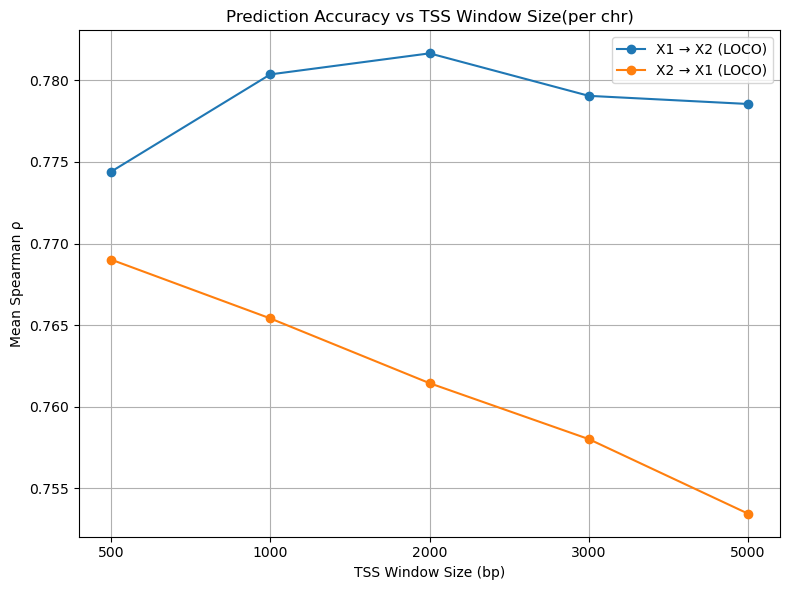

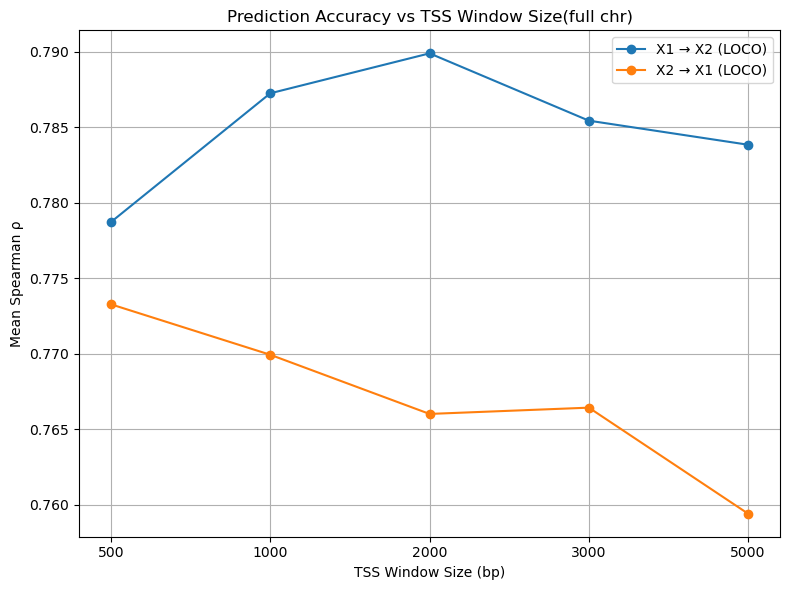

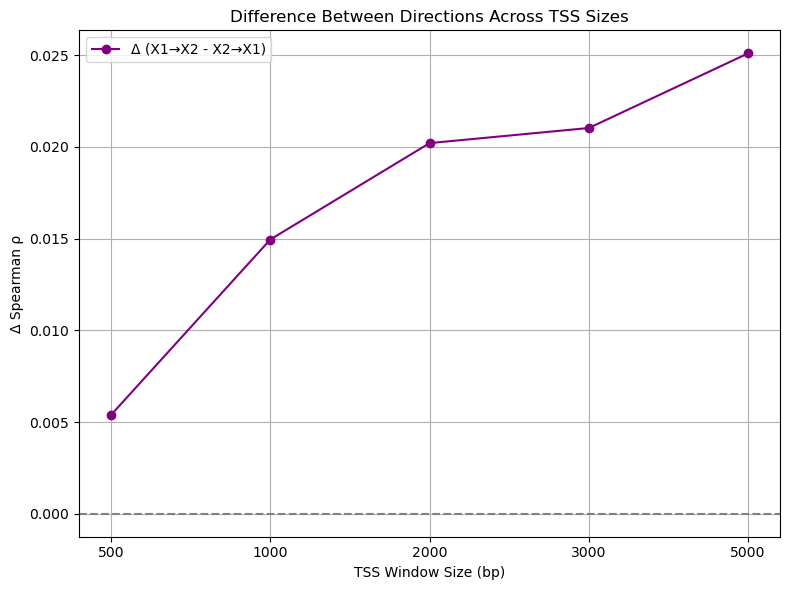

In [10]:
summary_df = pd.DataFrame(results_summary)

# 將 'default' 改成 '5000'
summary_df["TSS"] = summary_df["TSS"].replace("default", "5000")

# 按 TSS 數值排序（確保正確順序）
summary_df = summary_df.sort_values("TSS", key=lambda s: s.map(int))

print("\n===== 📊 Summary of All TSS Window Sizes =====")
print(summary_df)

# ============================================================
#                  📈 Visualization
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(summary_df["TSS"], summary_df["X1_to_X2"], marker='o', label="X1 → X2 (LOCO)")
plt.plot(summary_df["TSS"], summary_df["X2_to_X1"], marker='o', label="X2 → X1 (LOCO)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Mean Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size(per chr)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(summary_df["TSS"], summary_df["X1_to_X2_full"], marker='o', label="X1 → X2 (LOCO)")
plt.plot(summary_df["TSS"], summary_df["X2_to_X1_full"], marker='o', label="X2 → X1 (LOCO)")
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Mean Spearman ρ")
plt.title("Prediction Accuracy vs TSS Window Size(full chr)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(summary_df["TSS"], summary_df["diff"], marker='o', color='purple', label="Δ (X1→X2 - X2→X1)")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("TSS Window Size (bp)")
plt.ylabel("Δ Spearman ρ")
plt.title("Difference Between Directions Across TSS Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
BASE_DIRS = [
    "../preprocessed_data/reference/1. merged data/with_y_500_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_1000_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_2000_one_side",
    "../preprocessed_data/reference/1. merged data/with_y_3000_one_side",
]
META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
chromosomes = [f"chr{i}" for i in range(2, 23)]

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
    }

# ============================================================
#                  FUNCTION: LOCO EXPERIMENT
# ============================================================
def run_loco(train_name, val_name, data_dir):
    """Perform Leave-One-Chromosome-Out CV."""
    print(f"\n==============================")
    print(f" 🔁 LOCO ({data_dir}): {train_name} → {val_name}")
    print(f"==============================")

    df_train_full = pd.read_csv(f"{data_dir}/{train_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    df_val_full   = pd.read_csv(f"{data_dir}/{val_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

    results = []

    for chrom_val in chromosomes:
        df_train = df_train_full[df_train_full["chr"] != chrom_val].copy()
        df_val   = df_val_full[df_val_full["chr"] == chrom_val].copy()

        if df_val.empty:
            continue

        X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
        X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dtrain, dval],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=0)
            ],
        )

        df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)
        rho = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
        results.append({"chr": chrom_val, "spearman": rho})

    summary_loco = pd.DataFrame(results)
    mean_loco = summary_loco["spearman"].mean()

    # --- Full model baseline ---
    X_train_full, y_train_full = df_train_full[feature_cols], df_train_full[TARGET_COL]
    X_val_full, y_val_full     = df_val_full[feature_cols], df_val_full[TARGET_COL]

    dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)
    dval_full   = lgb.Dataset(X_val_full, label=y_val_full, reference=dtrain_full)

    full_model = lgb.train(
        params,
        dtrain_full,
        valid_sets=[dtrain_full, dval_full],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ],
    )

    df_val_full["pred_full"] = full_model.predict(X_val_full, num_iteration=full_model.best_iteration)
    rho_full = spearmanr(df_val_full[TARGET_COL], df_val_full["pred_full"])[0]

    return mean_loco, rho_full

# ============================================================
#                  MAIN LOOP OVER TSS WINDOW SIZES
# ============================================================
results_summary = []

for data_dir in BASE_DIRS:
    tss_label = os.path.basename(data_dir).replace("with_y_", "").replace("with_y", "default")

    print(f"\n🏁 Running TSS={tss_label}")
    mean_X1_to_X2, full_X1_to_X2 = run_loco("X1", "X2", data_dir)
    mean_X2_to_X1, full_X2_to_X1 = run_loco("X2", "X1", data_dir)

    results_summary.append({
        "TSS": tss_label,
        "X1_to_X2": mean_X1_to_X2,
        "X2_to_X1": mean_X2_to_X1,
        "X1_to_X2_full": full_X1_to_X2,
        "X2_to_X1_full": full_X2_to_X1,
        "diff": mean_X1_to_X2 - mean_X2_to_X1
    })

In [13]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X2_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,   # reproducibility flag (>= LGBM 4.0)
    "force_row_wise": True,  # prevent threading non-determinism
}

# ============================================================
#                  CROSS-CHROMOSOME TRAINING
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")
    
    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)

    # -----------------------------
    # Evaluate Spearman correlation
    # -----------------------------
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
    print(f"\n📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    print("📊 Per-Chromosome Spearman Correlation:")

    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["pred"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        print(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

# --- 收集所有 per-chr spearman ---
chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

# --- 計算每個 chr 的平均 ---
chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean().rename(columns={"spearman": "mean_spearman"})

# ============================================================
#                  PRINT RESULTS
# ============================================================
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")

print("\n===== Per-Chromosome Mean Spearman =====")
print(chr_mean.sort_values("mean_spearman", ascending=False))
print(f"\nOverall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 456

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0666904	val's rmse: 0.190953
[400]	train's rmse: 0.0355242	val's rmse: 0.190126
Early stopping, best iteration is:
[381]	train's rmse: 0.0376451	val's rmse: 0.189838

📈 Fold 1 Overall Spearman ρ = 0.6865
📊 Per-Chromosome Spearman Correlation:
   chr12 : ρ = 0.7536
   chr17 : ρ = 0.7440
   chr2  : ρ = 0.7182
   chr22 : ρ = 0.7110
   chr7  : ρ = 0.7591

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	train's rmse: 0.105647	val's rmse: 

# Train on rank transform groupby cell line

In [14]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
TRAIN_PATH = "../preprocessed_data/CAGE-merged/X1_all_rank_features.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/X2_all_rank_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,   # reproducibility flag (>= LGBM 4.0)
    "force_row_wise": True,  # prevent threading non-determinism
}

# ============================================================
#                  CROSS-CHROMOSOME TRAINING
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")
    
    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)

    # -----------------------------
    # Evaluate Spearman correlation
    # -----------------------------
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
    print(f"\n📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")
    print("📊 Per-Chromosome Spearman Correlation:")

    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["pred"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        print(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

# --- 收集所有 per-chr spearman ---
chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

# --- 計算每個 chr 的平均 ---
chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean().rename(columns={"spearman": "mean_spearman"})

# ============================================================
#                  PRINT RESULTS
# ============================================================
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")

print("\n===== Per-Chromosome Mean Spearman =====")
print(chr_mean.sort_values("mean_spearman", ascending=False))
print(f"\nOverall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 456

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	train's rmse: 0.0956605	val's rmse: 0.190943

📈 Fold 1 Overall Spearman ρ = 0.7379
📊 Per-Chromosome Spearman Correlation:
   chr12 : ρ = 0.7499
   chr17 : ρ = 0.7369
   chr2  : ρ = 0.7297
   chr22 : ρ = 0.7281
   chr7  : ρ = 0.7449

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	train's rmse: 0.105695	val's rmse: 0.197202

📈 Fold 2 Overall Spearman ρ = 0.7439
📊 Per-Chromosome Spearman Correlation:
   chr13 : ρ = 0.

# Train on leave one chr out method on X1 -> X2, X2 -> X1

In [2]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
DATA_DIR = "../preprocessed_data/reference/1. merged data/with_y_500"
META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"
chromosomes = [f"chr{i}" for i in range(2, 23)]

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
        "boosting_type": "gbdt",
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
    }
# ============================================================
#                  FUNCTION: LOCO EXPERIMENT
# ============================================================
def run_loco(train_name, val_name):
    """Perform Leave-One-Chromosome-Out CV: train on `train_name`, validate on `val_name`"""
    print(f"\n==============================")
    print(f" 🔁 LOCO: {train_name} → {val_name}")
    print(f"==============================")

    df_train_full = pd.read_csv(f"{DATA_DIR}/{train_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    df_val_full   = pd.read_csv(f"{DATA_DIR}/{val_name}_all_logzscore_logzscore_with_y.tsv", sep="\t")
    feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

    results = []

    # ---------------- LOCO LOOP ----------------
    for chrom_val in chromosomes:
        print(f"\n🚀 Leave-One-Chromosome-Out: {chrom_val}")

        train_chrs = [c for c in chromosomes if c != chrom_val]
        df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
        df_val   = df_val_full[df_val_full["chr"] == chrom_val].copy()

        X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
        X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dtrain, dval],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=200)
            ],
        )

        df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)
        rho = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
        print(f"📈 {chrom_val} Spearman ρ = {rho:.4f}")

        results.append({"chr": chrom_val, "spearman": rho})

    # ---------------- LOCO SUMMARY ----------------
    summary_loco = pd.DataFrame(results)
    mean_loco = summary_loco["spearman"].mean()
    print(f"\nMean Spearman (LOCO {train_name}→{val_name}): {mean_loco:.4f}")

    # ---------------- Full Model Baseline ----------------
    print("\n🏋️ Training Full Model (all chr)...")
    X_train_full, y_train_full = df_train_full[feature_cols], df_train_full[TARGET_COL]
    X_val_full, y_val_full     = df_val_full[feature_cols], df_val_full[TARGET_COL]

    dtrain_full = lgb.Dataset(X_train_full, label=y_train_full)
    dval_full   = lgb.Dataset(X_val_full, label=y_val_full, reference=dtrain_full)

    full_model = lgb.train(
        params,
        dtrain_full,
        valid_sets=[dtrain_full, dval_full],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val_full["pred_full"] = full_model.predict(X_val_full, num_iteration=full_model.best_iteration)
    rho_full = spearmanr(df_val_full[TARGET_COL], df_val_full["pred_full"])[0]
    print(f"\n🌍 Full model ({train_name}→{val_name}) Spearman ρ = {rho_full:.4f}")

    # ---------------- Comparison ----------------
    summary_loco["direction"] = f"{train_name}→{val_name}"
    summary_loco["full_model_rho"] = rho_full
    summary_loco["delta_vs_full"] = summary_loco["spearman"] - rho_full

    print("\n===== LOCO vs Full Model Comparison =====")
    print(summary_loco.sort_values("delta_vs_full", ascending=False))
    print(f"\nAverage Δ(LOCO − Full): {summary_loco['delta_vs_full'].mean():.4f}")

    return summary_loco


# ============================================================
#                  RUN BOTH DIRECTIONS
# ============================================================
summary_X1_to_X2 = run_loco("X1", "X2")
summary_X2_to_X1 = run_loco("X2", "X1")

# ============================================================
#                  COMBINED SUMMARY
# ============================================================
summary_all = pd.concat([summary_X1_to_X2, summary_X2_to_X1], ignore_index=True)
print("\n===== Combined LOCO Summary =====")
print(summary_all)

# Save results (optional)
summary_all.to_csv("summary_LOCO_X1X2_comparison.tsv", sep="\t", index=False)

# ============================================================
#                  GLOBAL SUMMARY STATS
# ============================================================
print("\n📊 Mean Spearman by direction:")
print(summary_all.groupby("direction")["spearman"].mean())

print("\n📊 Mean Δ(LOCO − Full):")
print(summary_all.groupby("direction")["delta_vs_full"].mean())


🔒 Global seed set to 42

 🔁 LOCO: X1 → X2

🚀 Leave-One-Chromosome-Out: chr2
Training until validation scores don't improve for 100 rounds
[200]	train's l2: 0.0145046	val's l2: 0.0322111
[400]	train's l2: 0.012123	val's l2: 0.0307976
[600]	train's l2: 0.0113228	val's l2: 0.0307107
Early stopping, best iteration is:
[576]	train's l2: 0.0113872	val's l2: 0.0305902
📈 chr2 Spearman ρ = 0.7664

🚀 Leave-One-Chromosome-Out: chr3
Training until validation scores don't improve for 100 rounds
[200]	train's l2: 0.0145778	val's l2: 0.0296464
[400]	train's l2: 0.0122144	val's l2: 0.0285991
Early stopping, best iteration is:
[495]	train's l2: 0.011676	val's l2: 0.0283721
📈 chr3 Spearman ρ = 0.7853

🚀 Leave-One-Chromosome-Out: chr4
Training until validation scores don't improve for 100 rounds
[200]	train's l2: 0.0147047	val's l2: 0.0284966
[400]	train's l2: 0.0123564	val's l2: 0.0273429
Early stopping, best iteration is:
[408]	train's l2: 0.0123001	val's l2: 0.0273205
📈 chr4 Spearman ρ = 0.7777

🚀 Lea

# mix X1, X2 predict leave chr

In [16]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
X1_PATH = "../preprocessed_data/CAGE-merged/X1_features.tsv"
X2_PATH = "../preprocessed_data/CAGE-merged/X2_features.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]  # 五折，每折約4條chr
print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING & MERGING
# ============================================================
df_X1 = pd.read_csv(X1_PATH, sep="\t")
df_X2 = pd.read_csv(X2_PATH, sep="\t")

# 加入 cell line label 方便日後分析
df_X1["cell_line"] = "X1"
df_X2["cell_line"] = "X2"

# 合併成完整 dataset
df_full = pd.concat([df_X1, df_X2], ignore_index=True)
feature_cols = [c for c in df_full.columns if c not in META_COLS + ["cell_line"]]

print(f"Combined data shape: {df_full.shape}")
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS
# ============================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  CHROMOSOME-BASED K-FOLD CV
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")

    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_full[df_full["chr"].isin(train_chrs)].copy()
    df_val   = df_full[df_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred"] = model.predict(X_val, num_iteration=model.best_iteration)

    # -----------------------------
    # Evaluate Spearman correlation
    # -----------------------------
    overall_spearman = spearmanr(df_val[TARGET_COL], df_val["pred"])[0]
    print(f"\n📈 Fold {fold_idx+1} Overall Spearman ρ = {overall_spearman:.4f}")

    # ---- per-chr correlation ----
    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        rho = spearmanr(subdf[TARGET_COL], subdf["pred"])[0]
        chr_corrs.append({"chr": chrom, "spearman": rho})
        print(f"   {chrom:<6s}: ρ = {rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": overall_spearman,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame([
    {"fold": r["fold"], "val_chr": ",".join(r["val_chr"]), "overall_spearman": r["overall_spearman"]}
    for r in results
])

# --- 收集所有 per-chr spearman ---
chr_rows = []
for r in results:
    for c in r["per_chr"]:
        chr_rows.append({"fold": r["fold"], "chr": c["chr"], "spearman": c["spearman"]})
summary_chr = pd.DataFrame(chr_rows)

# --- 計算每個 chr 的平均 ---
chr_mean = summary_chr.groupby("chr", as_index=False)["spearman"].mean().rename(columns={"spearman": "mean_spearman"})

# ============================================================
#                  PRINT RESULTS
# ============================================================
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean Spearman (across folds): {summary_fold['overall_spearman'].mean():.4f}")

print("\n===== Per-Chromosome Mean Spearman =====")
print(chr_mean.sort_values("mean_spearman", ascending=False))
print(f"\nOverall mean of per-chromosome means: {chr_mean['mean_spearman'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Combined data shape: (32568, 466)
Feature count: 456

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.0968828	val's rmse: 0.148716
Early stopping, best iteration is:
[253]	train's rmse: 0.0883764	val's rmse: 0.148628

📈 Fold 1 Overall Spearman ρ = 0.7623
   chr12 : ρ = 0.7963
   chr17 : ρ = 0.7598
   chr2  : ρ = 0.7719
   chr22 : ρ = 0.7671
   chr7  : ρ = 0.7796

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.10283	val's rmse: 0.148603
Early stopping, best iteration is:
[138]	train's rmse: 0.113515	val's rmse: 0.1484